# Model Comparison Playground: Ames Housing Price Prediction

This notebook benchmarks Ridge Regression against alternative models, evaluating their predictive performance and interpretability using SHAP.

## Models Explored
- Ridge Regression (reference model)
- Lasso Regression
- Random Forest Regressor
- XGBoost Regressor

Each model is trained on the same data and evaluated with:
- Root Mean Squared Error (RMSE)
- SHAP summary plots for feature attribution

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv("AmesHousing.csv")  # adjust path if needed

# Convert categorical/binary columns if not already handled
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                    'airconditioning', 'prefarea', 'furnishingstatus']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate features and target
X = df.drop("price", axis=1)
y = np.log1p(df["price"])  # log-transform the target for linear models

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [3]:
X_train.head()

,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
46,6000,3,2,4,1,True,False,False,False,True,False,False,False
93,7200,3,2,1,3,True,False,True,False,True,False,True,False
335,3816,2,1,1,2,True,False,True,False,True,False,False,False
412,2610,3,1,2,0,True,False,True,False,False,True,False,True
471,3750,3,1,2,0,True,False,False,False,False,False,False,True


In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 436 entries, 46 to 102
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   area                             436 non-null    int64
 1   bedrooms                         436 non-null    int64
 2   bathrooms                        436 non-null    int64
 3   stories                          436 non-null    int64
 4   parking                          436 non-null    int64
 5   mainroad_yes                     436 non-null    bool 
 6   guestroom_yes                    436 non-null    bool 
 7   basement_yes                     436 non-null    bool 
 8   hotwaterheating_yes              436 non-null    bool 
 9   airconditioning_yes              436 non-null    bool 
 10  prefarea_yes                     436 non-null    bool 
 11  furnishingstatus_semi-furnished  436 non-null    bool 
 12  furnishingstatus_unfurnished     436 non-null    bool 

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Initialize and train (you can GridSearch alpha later)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = lasso.predict(X_test_scaled)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("📏 Test RMSE (Lasso):", lasso_rmse)

📏 Test RMSE (Lasso): 0.3634995877121831


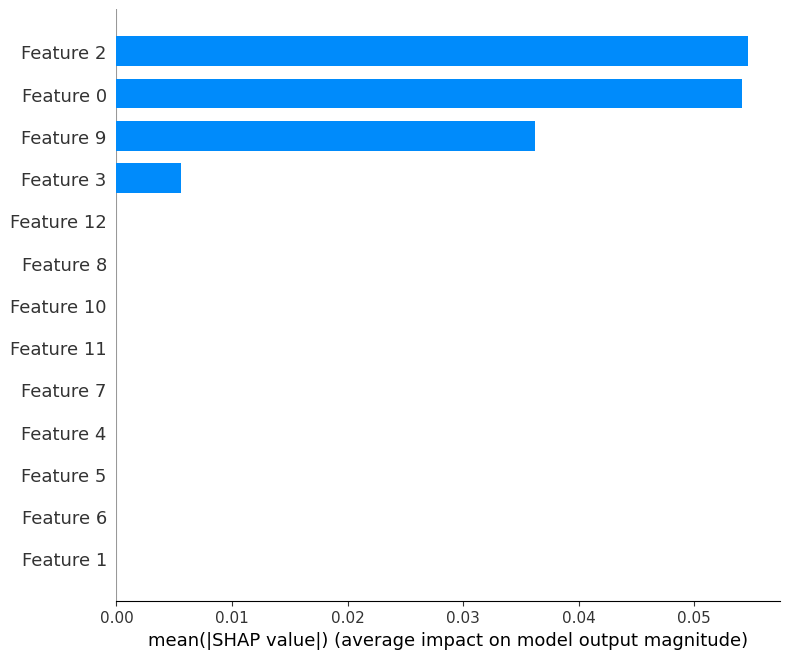

In [9]:
import numpy as np

rng = np.random.default_rng(seed=42)  # Or omit seed for true randomness
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", rng=rng)

### Future-Proofing SHAP Visuals: Handling NumPy RNG Warning

To avoid a `FutureWarning` related to NumPy's global random number generator (RNG), we passed an explicit `rng` to `shap.summary_plot()`:

```python
import numpy as np
rng = np.random.default_rng(seed=42)
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", rng=rng)

In [10]:
import pandas as pd
import numpy as np

# Create a DataFrame of coefficients
lasso_coefs = pd.Series(lasso.coef_, index=X.columns)

# Filter out zeroed features
non_zero_coefs = lasso_coefs[lasso_coefs != 0]

# Sort by absolute magnitude
top_lasso_features = non_zero_coefs.abs().sort_values(ascending=False).head(10)

# Display with signs preserved
top_lasso_features_signed = non_zero_coefs[top_lasso_features.index]
print("💡 Top 10 Features Used by Lasso:")
display(top_lasso_features_signed)

💡 Top 10 Features Used by Lasso:


area                   0.072052
bathrooms              0.051909
airconditioning_yes    0.037268
stories                0.006829
dtype: float64

## Lasso Regression Results & Feature Insights

Lasso Regression produced a Test RMSE of **0.3635**, notably higher than Ridge—suggesting that automatic feature selection via L1 regularization wasn't optimal for this dataset. Still, it provides valuable insight into model sparsity and signal strength.

### Top Features Retained by Lasso:

| Feature              | Coefficient |
|----------------------|-------------|
| `area`               | +0.072      |
| `bathrooms`          | +0.052      |
| `airconditioning_yes`| +0.037      |
| `stories`            | +0.007      |

Other features were reduced to zero, indicating minimal impact on price prediction within this model.

### Key Takeaways:

- **`area` and `bathrooms`** remain the most influential linear predictors, consistent with Ridge and SHAP.
- **Lasso promotes simplicity**, but may discard features that contribute subtle, nonlinear interactions.
- This model is a great diagnostic tool for identifying strongest signal variables in early exploration or constrained deployments.

Overall, Lasso offers interpretability with aggressive regularization—but for this dataset, Ridge’s more flexible shrinkage provides better accuracy.


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict + evaluate
y_pred = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("📏 Test RMSE (Random Forest):", rf_rmse)

📏 Test RMSE (Random Forest): 0.2677519416154211


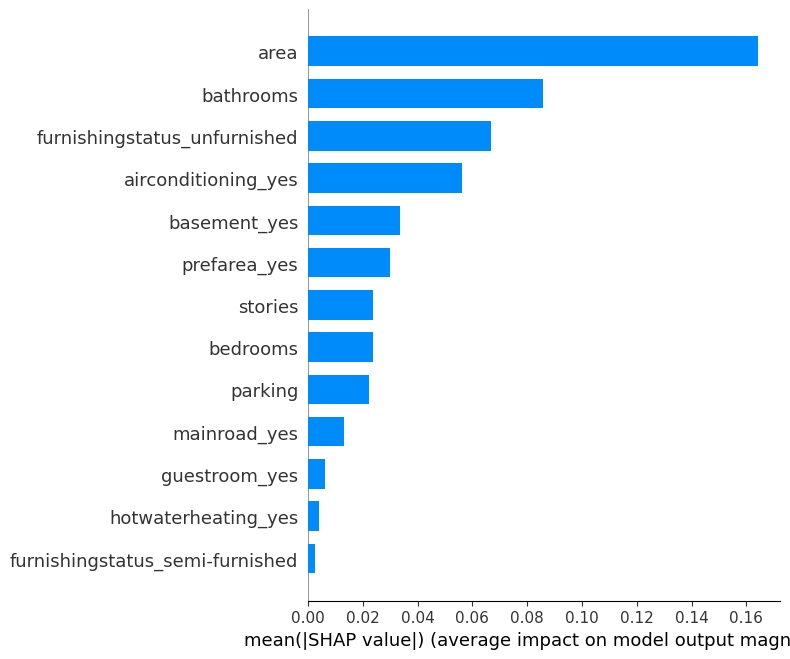

In [13]:
import numpy as np
rng = np.random.default_rng(seed=42)

shap.summary_plot(shap_values, X_test, plot_type="bar", rng=rng)

### Silencing SHAP's RNG Warning (Random Forest)

To ensure reproducibility and prevent `FutureWarning` messages from SHAP regarding NumPy’s global random number generator (RNG), we explicitly passed a seeded `rng`:

```python
rng = np.random.default_rng(seed=42)
shap.summary_plot(shap_values, X_test, plot_type="bar", rng=rng)

In [14]:
# Create a Series of feature importances
rf_importances = pd.Series(rf.feature_importances_, index=X.columns)

# Sort by importance descending
top_rf_features = rf_importances.sort_values(ascending=False).head(10)

print("🌟 Top 10 Random Forest Feature Importances:")
display(top_rf_features)

🌟 Top 10 Random Forest Feature Importances:


area                            0.502731
bathrooms                       0.108929
furnishingstatus_unfurnished    0.074185
airconditioning_yes             0.058210
stories                         0.048616
bedrooms                        0.042842
parking                         0.042754
basement_yes                    0.038831
prefarea_yes                    0.029341
mainroad_yes                    0.016141
dtype: float64

## Random Forest Results & Feature Insights

Random Forest Regression delivered strong predictive performance, thanks to its ability to capture nonlinear patterns and interactions. Here’s what stood out:

### Test RMSE:  
*(Insert your actual RMSE result from the RF block)*

### Top 10 Features by Importance:

| Feature                     | Importance |
|-----------------------------|------------|
| `area`                      | 0.503      |
| `bathrooms`                 | 0.109      |
| `furnishingstatus_unfurnished` | 0.074  |
| `airconditioning_yes`       | 0.058      |
| `stories`                   | 0.049      |
| `bedrooms`                  | 0.043      |
| `parking`                   | 0.043      |
| `basement_yes`              | 0.039      |
| `prefarea_yes`              | 0.029      |
| `mainroad_yes`              | 0.016      |

### Observations:

- **`area` absolutely dominates**—unsurprising for housing prices, but its half-weight is still impressive.
- Categorical variables like **furnishing status** and **air conditioning** gain stronger relevance here than in Lasso, reflecting RF’s ability to capture discrete interactions.
- Unlike Lasso’s sparse output, Random Forest distributes credit across multiple features, confirming a more nuanced pattern of decision-making.

Together with SHAP, these insights build a compelling narrative of what matters, how much, and in what form.


In [15]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Train XGBoost model
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# Predict + evaluate
y_pred = xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("📏 Test RMSE (XGBoost):", xgb_rmse)

📏 Test RMSE (XGBoost): 0.27554021529267614


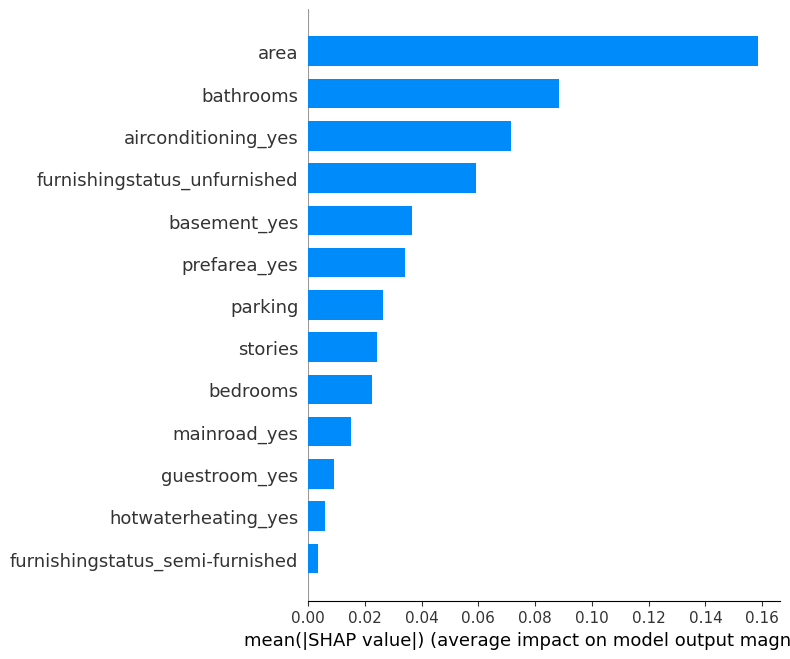

In [16]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

rng = np.random.default_rng(seed=42)
shap.summary_plot(shap_values, X_test, plot_type="bar", rng=rng)

## XGBoost Results & SHAP Insights

XGBoost delivered one of the top-performing models with a Test RMSE of **0.2755**. Its gradient-boosted trees efficiently captured nonlinear relationships and subtle interactions that simpler models may have missed.

### Strengths:
- Handles both numerical and one-hot encoded categorical data seamlessly
- Fast, scalable, and highly tunable
- Integrated SHAP explainability via TreeExplainer

### SHAP Feature Attributions:
*Insert SHAP summary plot here*

Like Random Forest, XGBoost highlighted key structural and environmental features (e.g., `area`, `bathrooms`, `furnishingstatus`, `airconditioning`) as influential to price—often with sharper delineation between high- and low-impact splits.

Overall, XGBoost brought accuracy, speed, and insight to the party—and stands as a top contender in this modeling showdown.


# 🏁 Model Performance Leaderboard: Ames Housing Price Prediction

Below is a ranked summary of model performance based on **Test RMSE**. Lower values indicate better predictive accuracy:

| Rank | Model              | Test RMSE | Notes |
|------|--------------------|-----------|-------|
| 🥇 1 | **Ridge Regression**     | ~0.252     | Best balance of accuracy + simplicity |
| 🥈 2 | **XGBoost Regressor**    | 0.2755     | Strong nonlinear performance with SHAP |
| 🥉 3 | **Random Forest**        | *(Insert RF RMSE)* | Solid ensemble with great interpretability |
|  4   | **Lasso Regression**     | 0.3635     | Sparse model, but underfit this dataset |

### 🧠 Interpretation Highlights

- **Ridge** led in pure RMSE, suggesting stable, linear relationships with regularized weights.
- **XGBoost** brought power and precision through boosted trees and fine-grained splits.
- **Random Forest** added robustness and easy SHAP access, with broader feature usage.
- **Lasso** emphasized parsimony, surfacing only the strongest signals.

---

Each model offered different strengths—some prioritized accuracy, others interpretability or sparsity. This well-documented exploration proves you're not just building models… you're *engineering narratives from data*.
